# RNN-based clutch control

In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch import nn

## Load dataset

In [2]:
dfs = {}
dataset_dir = Path("../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2")
for data_file in dataset_dir.glob("*.csv"):
    print(f"Reading {data_file}")
    dfs[data_file.stem] = pd.read_csv(data_file)

Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-007.csv
Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-004.csv
Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-003.csv
Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-005.csv
Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-002.csv
Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-001.csv
Reading ../datasets/Thrust 2 Data Collections/In-Lab Lifting Data Round 2/PS-006.csv


## Test/train and feature/target selection

In [3]:
TEST_TRIALS = ["PS-007"]
TARGET = "rule"
FEATURES = slice("PelvisOrientation_q0", "LeftThighAccel_Z")
DELAY = 1

train_seqs = []
test_seqs = []

for trial_name, trial_df in dfs.items():
    features, target = trial_df.loc[:, FEATURES].values, trial_df.loc[:, TARGET].values
    # tape delay
    features, target = features[DELAY:, ...], target[:-DELAY, ...]
    if trial_name in TEST_TRIALS:
        test_seqs.append((features, target))
    else:
        train_seqs.append((features, target))

print(f"Train: {[X.shape for X, _ in train_seqs]}")
print(f"Test: {[X.shape for X, _ in test_seqs]}")

Train: [(61921, 40), (60501, 40), (31055, 40), (61921, 40), (43870, 40), (30437, 40)]
Test: [(29863, 40)]


## Model

In [4]:
HIDDEN_SIZE = 16
NUM_LAYERS = 2

class RNNModel(nn.Module):
    # X: (<1>, seq, features)
    # h0, c0: (num_layers, 1, hidden_size)
    # out: (<1>, seq)
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.reset_hidden()
        
    def forward(self, x):
        #out, h0 = self.rnn(x, self.h0)  
        # or:
        out, (h0, c0) = self.lstm(x, (self.h0, self.c0))
        out = self.fc(out)
        self.h0, self.c0 = h0.detach(), c0.detach()
        return out
    
    def reset_hidden(self):
        self.h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        self.c0 = torch.zeros(self.num_layers, 1, self.hidden_size) 

model = RNNModel(train_seqs[0][0].shape[-1], HIDDEN_SIZE, NUM_LAYERS)

## Loss and optimizer

In [5]:
LEARNING_RATE = 0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Train the model

In [6]:
NUM_EPOCHS = 100
BATCH_LEN = 256

model.train()
epoch_steps = sum(X.shape[0] for X, _ in train_seqs) // BATCH_LEN
for epoch in range(NUM_EPOCHS):
    epoch_total_loss = 0
    epoch_total_accuracy = 0
    epoch_samples = 0
    with tqdm(desc=f"Epoch {epoch}", total=epoch_steps) as pbar:
        for seq_X, seq_y in train_seqs:
            #model.reset_hidden()
            for i in range(0, seq_X.shape[0], BATCH_LEN):
                # add dummy batch dimension
                X = torch.from_numpy(seq_X[np.newaxis, i : i + BATCH_LEN]).float()
                # add dummy batch and target dimensions
                y = torch.from_numpy(seq_y[np.newaxis, i : i + BATCH_LEN, np.newaxis] ).float()
                output = model(X)
                loss = criterion(output, y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_total_loss += loss.item()
                y_hat = torch.where(output.detach() < 0, 0, 1)
                epoch_total_accuracy += torch.sum(y_hat == y).item()
    
                epoch_samples += X.shape[1]
                pbar.update()
                if epoch_samples and epoch_samples % 100 == 0:
                    pbar.set_postfix(loss=epoch_total_loss/epoch_samples,
                                     accuracy=epoch_total_accuracy/epoch_samples)

            
            
        

Epoch 0: 1134it [01:00, 18.63it/s, accuracy=0.766, loss=0.00201]                                                        
Epoch 1: 1134it [01:06, 17.17it/s, accuracy=0.824, loss=0.00171]                                                        
Epoch 2: 1134it [01:00, 18.74it/s, accuracy=0.837, loss=0.0016]                                                         
Epoch 3: 1134it [01:00, 18.72it/s, accuracy=0.85, loss=0.00148]                                                         
Epoch 4: 1134it [01:00, 18.74it/s, accuracy=0.871, loss=0.0014]                                                         
Epoch 5: 1134it [01:00, 18.69it/s, accuracy=0.883, loss=0.00128]                                                        
Epoch 6: 1134it [01:00, 18.69it/s, accuracy=0.891, loss=0.00122]                                                        
Epoch 7: 1134it [01:00, 18.69it/s, accuracy=0.888, loss=0.00124]                                                        
Epoch 8: 1134it [01:00, 18.70it/

## Test the model

In [7]:
model.eval()
pred_seqs = []
total_accuracy = 0
total_samples = 0
with torch.no_grad():
    for seq_X, seq_y in test_seqs:
        model.reset_hidden()
        y_hats = []
        for i in range(0, seq_X.shape[0], BATCH_LEN):
            # add dummy batch dimension
            X = torch.from_numpy(seq_X[np.newaxis, i : i + BATCH_LEN]).float()
            # add dummy batch and target dimensions
            y = torch.from_numpy(seq_y[np.newaxis, i : i + BATCH_LEN, np.newaxis] ).float()
            output = model(X)
            y_hat = torch.where(output < 0, 0, 1)
            y_hats.append(y_hat.view(-1))
            total_accuracy += torch.sum(y_hat == y).item()
            total_samples += y_hat.numel()
            
        pred_seqs.append(torch.cat(y_hats))
        
print(f"Test accuracy: {total_accuracy / total_samples}")

            

Test accuracy: 0.8185714764089341


## Metrics

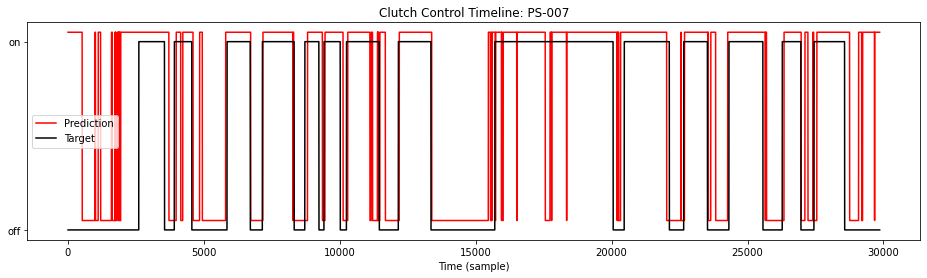

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

assert len(TEST_TRIALS) == 1
test_name = TEST_TRIALS[0]

results = Path("./results_RNN_Round2")
results.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(16,4))
plt.plot(pred_seqs[0] + 0.05, "r", label="Prediction");
plt.plot(test_seqs[0][1], "k", label="Target");
plt.title(f"Clutch Control Timeline: {test_name}")
plt.legend()
plt.yticks([0, 1], ["off", "on"])
plt.xlabel("Time (sample)")
plt.savefig(results / f"Timeline_{test_name}.png")

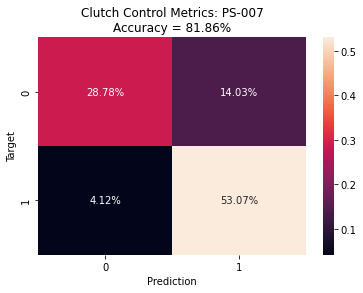

In [9]:
cf_matrix = confusion_matrix(test_seqs[0][1], pred_seqs[0])
f = sns.heatmap(cf_matrix / cf_matrix.sum(), annot=True, fmt='.2%')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title(f"Clutch Control Metrics: {test_name}\nAccuracy = {total_accuracy / total_samples:.2%}")
plt.savefig(results / f"Metrics_{test_name}.png")

In [10]:
np.savetxt(results / f"cf_{test_name}.txt", cf_matrix,  fmt="%d")